In [17]:
import sys, os

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

<h1> Loading the Dataset</h1>

In [84]:
#Loading dataset

#dataset = '100k/' #100k dataset path
dataset = '1M/' #1M dataset path
#dataset = '10M/' #10M dataset path
#dataset = '20M/' #20M dataset path

dataset_path = '../../Datasets/movieLens/' + dataset; # Full dataset path

filenames = {'movie': 'movie.csv', 'rating': 'rating.csv'};

time_zero = time.time();

global df_ratings;
df_ratings = pd.read_csv(dataset_path+filenames['rating']);
print "[Loading Time:",time.time()-time_zero,"s]",filenames['rating'],'Shape: ', df_ratings.shape;

[Loading Time: 0.304883956909 s] rating.csv Shape:  (1000209, 4)


<h1>Creating Utility Matrix</h1>

In [85]:
# Auxiliary Functions
global R;
global results_path;
results_path = './Results/';

global usersIds;
global moviesIds;

def InitializeIds():
    global usersIds;
    global moviesIds;


    usersIds = np.zeros(1);
    moviesIds = np.zeros(1);


    for count in xrange(len(df_ratings['rating'])):

        if df_ratings['userId'][count] in usersIds:
            pass;
        else:
            usersIds = np.append(usersIds, df_ratings['userId'][count]);   

        if df_ratings['movieId'][count] in moviesIds:
            pass;
        else:
            moviesIds = np.append(moviesIds, df_ratings['movieId'][count]);
            currentMovieId = df_ratings['movieId'][count];


def InitializeUtilityMatrix():
    InitializeIds();
    return np.zeros((usersIds.shape[0], moviesIds.shape[0]));

def FillUtilityMatrix():
    global R;
    for register in xrange(len(df_ratings['userId'])):
        userId = df_ratings['userId'][register];
        movieId = df_ratings['movieId'][register];

        #Getting userIndex from usersIds
        #itemindex = numpy.where(array==item) --> Return an array with indexes found
        userIndex = np.where(usersIds == userId);
        if len(userIndex[0]) == 0: # If userIndex hasn't found any matching user id in usersIds array
            print "UserId", userId, "not found in usersIds array.";
            pass;
        else:
            try:
                if len(userIndex[0]) > 1:
                    print "UserId ", userId, "is double-counted in usersIds.";
                userIndex = userIndex[0][0]; #Get the first occurance of userId match
            except IndexError:
                print "Error with user index: ", userIndex[0] ;
                pass;


        #Getting movieIndex from moviesIds
        #itemindex = numpy.where(array==item) --> Return an array with indexes found
        movieIndex = np.where(moviesIds == movieId);
        if len(movieIndex[0]) == 0: # If userIndex hasn't found any matching user id in usersIds array
            print "MovieId", movieId, "not found in usersIds array.";
            pass;
        else:
            try:
                if len(movieIndex[0]) > 1:
                    print "MovieId ", movieId, "is double-counted in moviesIds.";
                movieIndex = movieIndex[0][0]; #Get the first occurance of movieId match
            except IndexError:
                print "Error with movie index: ", movieIndex[0] ;
                pass;            

        R[userIndex][movieIndex] = df_ratings['rating'][register];
        
    return R;

def saveVariable(filename, variable):
    
    compression_parameter = 9;
    
    filepath = results_path+"Variables/"+dataset+filename;
    print "[*] Saving variable to " + filepath + " file...";
    if os.path.isfile(filepath): #Check if file already exists
        print "[*] Removing existing file...";
        os.remove(filepath);
        print "[+] Existing file removed.";    

    #joblib.dump(value, filename, compress=0, protocol=None, cache_size=None)
    joblib.dump(variable, filepath, compress = compression_parameter);
    print "[+] File saved.";   


In [86]:
time_zero = time.time();
global R;
R = InitializeUtilityMatrix();

print "Elapsed time: ", time.time()-time_zero;

R = FillUtilityMatrix();

print R.shape
print "Elapsed time: ", time.time()-time_zero;

(6041, 3707)


[*] Saving results to./Results/Figures/1M/ folder...
[+] Results saved.
Elapsed time:  0.741940975189


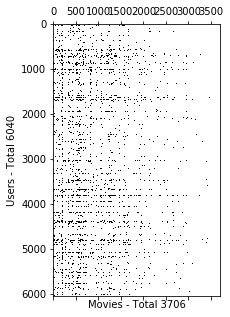

In [87]:
# Visualizing Matrix Sparsity
time_zero = time.time();

%matplotlib inline

#OS = calculateOverallSparsityMeasure(R);

fig, ax = plt.subplots(figsize = (5,5));

ax.spy(R);

plt.xlabel("Movies - Total "+str(R.shape[1]-1), fontsize = 10)
plt.ylabel("Users - Total "+str(R.shape[0]-1), fontsize = 10)
#plt.title("OS: " + str(OS) + '\n', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=10)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'unsortedUtilityMatrix.png')

print "[+] Results saved."

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h1> Reducing Dimensionality </h1>

In [92]:
U,s,V = np.linalg.svd(R, full_matrices = False);

print U.shape, s.shape, V.shape

(6041, 3707) (3707,) (3707, 3707)


In [96]:
S = np.zeros((s.shape[0], s.shape[0]))

S = np.diag(s)
print S.shape

(3707, 3707)


In [97]:

print np.allclose(R, np.dot(U, np.dot(S,V)))

True


<h1>Creating Training and Testing Dataset</h1>

In [89]:
x_train, x_test = train_test_split(R);
print x_train.shape, '[',float(x_train.shape[0])/R.shape[0],']';
print x_test.shape, '[', float(x_test.shape[0])/R.shape[0],']';

#x_train, x_test = train_test_split(S);

#print x_train.shape, '[',float(x_train.shape[0])/S.shape[1],']';
#print x_test.shape, '[', float(x_test.shape[0])/S.shape[1],']';

(4530, 3707) [ 0.749875848369 ]
(1511, 3707) [ 0.250124151631 ]


<h1>Creation and Initialization of a Single Hidder Layer Autoencoder</h1>

In [91]:
num_neurons = 10

inputDim = x_train.shape[1] #Number of items

autoencoder = Sequential([
                          Dense(num_neurons, activation = 'selu', kernel_initializer = 'uniform', input_dim = inputDim),
                          Dense(inputDim, activation = 'tanh', kernel_initializer = 'uniform')
                         ])

#SGD = optimizers.SGD(lr=0.5, momentum=0.00, decay=0.0, nesterov=False)

autoencoder.compile(optimizer = 'adam', loss='mse', metrics=['accuracy', 'mae'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 10)                37080     
_________________________________________________________________
dense_25 (Dense)             (None, 3707)              40777     
Total params: 77,857
Trainable params: 77,857
Non-trainable params: 0
_________________________________________________________________


<h1>Fitting the Model to Data</h1>

In [77]:
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')

time_zero = time.time()

fitHistory = autoencoder.fit(x_train, 
                             x_train, 
                             epochs = 2000,
                             verbose = 0,
                             shuffle = True,
                             validation_data = (x_test, x_test), 
                             callbacks = [earlyStopping])

print('Time to fit model: '+str(time.time()-time_zero)+' seconds')

Time to fit model: 1.28046798706 seconds


<h1>Visualizing Training History</h1>

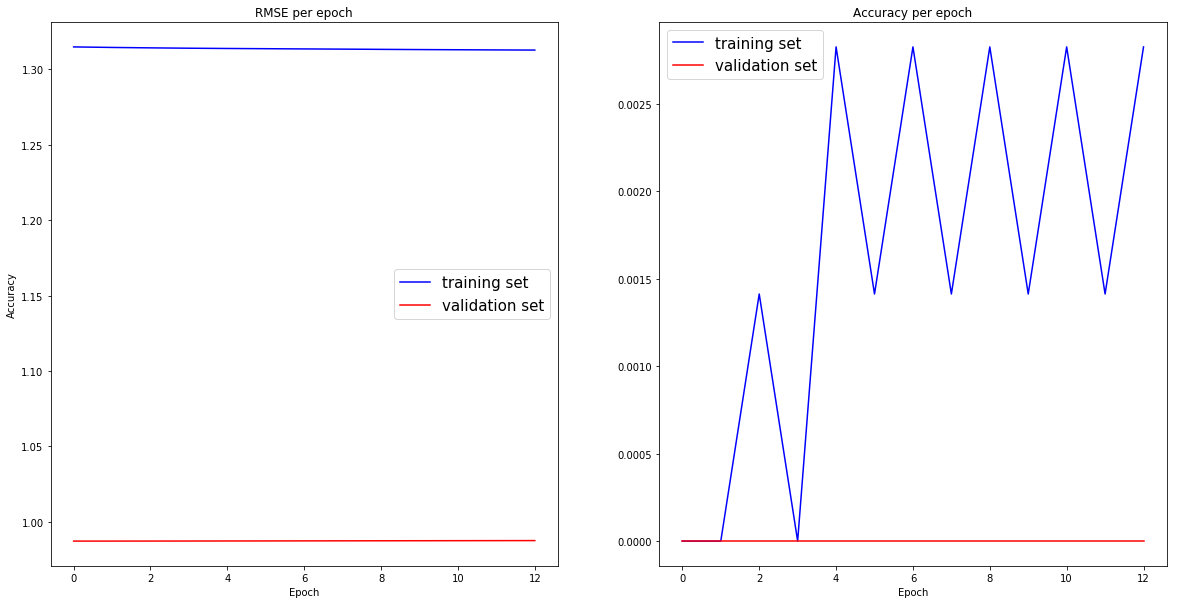

In [78]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(figsize = (20,10), nrows = 1, ncols = 2)

ax1.set_title('RMSE per epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('RMSE')
trainingSet_1, = ax1.plot(np.sqrt(fitHistory.history['loss']), 'b', label = 'trainig set')

validationSet_1, = ax1.plot(np.sqrt(fitHistory.history['val_loss']), 'r', label = 'validation set')

ax1.legend(handles=[trainingSet_1, validationSet_1], labels=['training set', 'validation set'], prop={'size': 15})


ax2.set_title('Accuracy per epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
trainingSet_2, = ax2.plot(fitHistory.history['acc'], 'b', label = 'training set')

validationSet_2, = ax2.plot(fitHistory.history['val_acc'], 'r', label = 'validation set')

ax2.legend(handles=[trainingSet_2, validationSet_2], labels=['training set', 'validation set'], prop={'size': 15})




#fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_autoencoder_30_40', 'pdf'), bbox_inches='tight')